# Python para Ciência de Dados - Trabalho Prático

## Carregar e preparar dados
Data set selecionado: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=results.csv

Todas as bases se encontram replicadas no repositório do projeto:
https://github.com/alexandrefortes/Python-para-Ciencia-de-Dados

## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Resultados dos pilotos
df_race_results = pd.read_csv('F1/results.csv').add_prefix('result_')

# Dados das corridas
df_races = pd.read_csv('F1/races.csv').add_prefix('race_')

# Dados dos construtores
df_constructors = pd.read_csv('F1/constructors.csv').add_prefix('constructor_')

# Dados dos circuitos
df_circuits = pd.read_csv('F1/circuits.csv').add_prefix('circuit_')

# Definição dos status
df_status = pd.read_csv('F1/status.csv').add_prefix('status_')

# Dados dos pilotos
df_drivers = pd.read_csv('F1/drivers.csv').add_prefix('driver_')

# Ajustando alguns nomes de colunas para melhor legibilidade
df_race_results.rename(columns={'result_number': 'result_car_number', 'result_grid': 'result_stating_grid', 'result_position': 'result_final_position', 'result_positionOrder' : 'result_final_rank'}, inplace=True)

# merge
merged_df = pd.merge(df_race_results, df_races, left_on='result_raceId', right_on='race_raceId', how='left')
merged_df = pd.merge(merged_df, df_drivers, left_on='result_driverId', right_on='driver_driverId', how='left')
merged_df = pd.merge(merged_df, df_constructors, left_on='result_constructorId', right_on='constructor_constructorId', how='left')
merged_df = pd.merge(merged_df, df_circuits, left_on='result_raceId', right_on='circuit_circuitId', how='left')
merged_df = pd.merge(merged_df, df_status, left_on='result_raceId', right_on='status_statusId', how='left')

# pandas não converteu automaticamente '\N' para NaN, então vamos fazer isso manualmente
merged_df = merged_df.replace(r'\\N', np.nan, regex=True)

# display(merged_df.isnull().sum())
# print(merged_df.columns)
# removendo algumas colunas que não serão utilizadas
merged_df.drop(['result_raceId', 'result_driverId','result_constructorId', 'result_car_number', 'result_positionText', 'result_statusId', 'race_raceId', 'race_round', 'race_circuitId', 'race_url', 'race_fp1_date', 'race_fp1_time', 'race_fp2_date','race_fp2_time', 'race_fp3_date', 'race_fp3_time', 'race_sprint_date', 'race_sprint_time','driver_driverId', 'driver_number', 'driver_code','constructor_constructorRef','constructor_url','circuit_circuitRef', 'circuit_lat', 'circuit_lng','circuit_url', 'status_statusId'], axis=1, inplace=True)
#print(merged_df.columns)

# Criar uma nova coluna 'win' que é 'True' se 'result_final_position' for 1 e 'False' caso contrário
merged_df['win'] = merged_df['result_final_rank'] == 1

In [33]:
# Teste: 
#victories_overview = merged_df[['constructor_name', 'driver_driverRef', 'result_stating_grid', 'result_final_position', 'result_final_rank', 'race_date', 'result_laps', 'status_status', 'win']]
#victories_overview

## Vitórias de contrutores por ano

In [3]:
wins_per_year_per_constructor = merged_df.groupby(['race_year', 'constructor_name'])['win'].sum().reset_index()
wins_per_year_per_constructor = wins_per_year_per_constructor.sort_values(by=['race_year', 'win'], ascending=[True, False])
wins_per_year_per_constructor = wins_per_year_per_constructor.query('win > 0')
print(wins_per_year_per_constructor.head(10))

    race_year constructor_name  win
1        1950       Alfa Romeo    6
8        1950     Kurtis Kraft    1
24       1951       Alfa Romeo    5
30       1951          Ferrari    3
33       1951     Kurtis Kraft    1
58       1952          Ferrari    7
63       1952            Kuzma    1
80       1953          Ferrari    7
83       1953     Kurtis Kraft    1
86       1953         Maserati    1


## Top 10 pilotos mais bem sucedidos em termos de pontos ganhos

In [4]:
successful_drivers = merged_df.groupby(['driver_forename', 'driver_surname'])['result_points'].sum().sort_values(ascending=False)
print(successful_drivers.head(10))

driver_forename  driver_surname
Lewis            Hamilton          4396.5
Sebastian        Vettel            3098.0
Fernando         Alonso            2061.0
Max              Verstappen        1983.5
Kimi             Räikkönen         1873.0
Valtteri         Bottas            1778.0
Nico             Rosberg           1594.5
Michael          Schumacher        1566.0
Daniel           Ricciardo         1307.0
Jenson           Button            1235.0
Name: result_points, dtype: float64


## Influência do grid de largada no resultado final

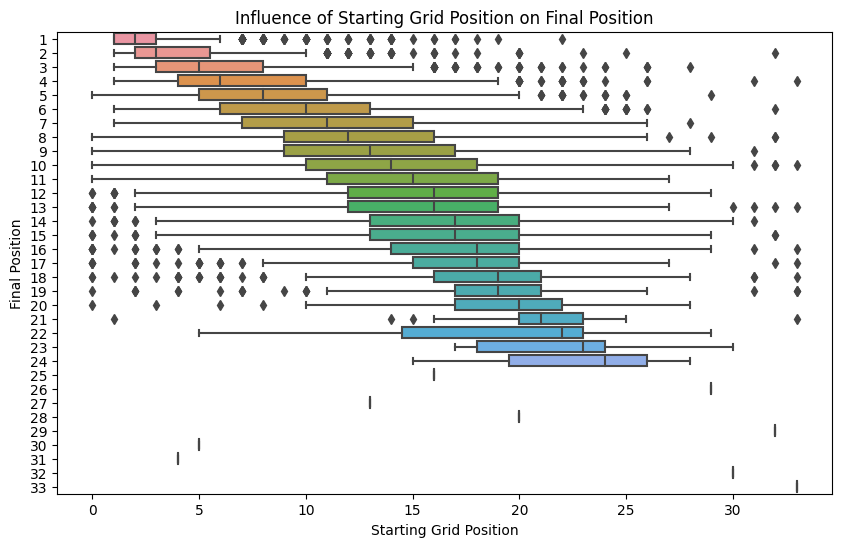

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='result_stating_grid', y='result_final_position', data=merged_df)
plt.title('Influence of Starting Grid Position on Final Position')
plt.xlabel('Starting Grid Position')
plt.ylabel('Final Position')
plt.show()

# Regressão/Classificação

A análise de dados da Fórmula 1 é bastante complexa. Entretanto, estamos usando um modelo de classificação simples para prever se um piloto terminará no podium (top 3) baseado em sua posição inicial (grid) e em que circuito a corrida está ocorrendo. Em uma análise real, seria necessário considerar muito mais fatores.

Um ponto de atenção para este tipo de base de dados, são outliers. Diferente de problemas relacionados a biologia, como o exemplo da base Iris, na fórmula 1 podemos ter outliers por diversos motivos inusitados, como acidentes, clima, problemas mecânicos, etc.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [84]:
# Limpar e preparar os dados
# Converter a coluna 'result_final_position' para numérico, substituindo quaisquer valores problemáticos por NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')
df = merged_df.copy()  # copiando o dataframe original para não alterá-lo
df = df.dropna(subset=['result_final_position'])  # remover linhas onde a posição final é desconhecida

In [85]:
# Converter a posição final para uma variável binária: 1 se o piloto terminar no podium (top 3), 0 caso contrário
df['podium'] = df['result_final_position'].apply(lambda x: 1 if x <= 3 else 0)

# Selecionar apenas as colunas que vamos utilizar
df = df[['result_stating_grid', 'race_year', 'race_name', 'constructor_name', 'driver_driverRef', 'podium']]
#print(df.head(10))

In [86]:
# Converter colunas categóricas para numéricas
race_name_le = LabelEncoder()
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()
#REVISAR PARA UMA INSTANCIA APENAS

# Converter colunas categóricas para numéricas
df['race_name_num'] = race_name_le.fit_transform(df['race_name'])
df['constructor_name_num'] = constructor_name_le.fit_transform(df['constructor_name'])
df['driver_driverRef_num'] = driver_driverRef_le.fit_transform(df['driver_driverRef'])
#print(df.head(10))

In [87]:
df_train = df.copy()  # copiando o dataframe para ter referência de conversão. Faremos isso porque precisamos usar o mesmo mapeamento para converter dados novos que o usuário fornecerá.
df_train.drop(['race_name', 'constructor_name', 'driver_driverRef'], axis=1, inplace=True)

In [88]:
# Dividir o conjunto de dados em treinamento e teste
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2324
           1       0.56      0.57      0.56       674

    accuracy                           0.80      2998
   macro avg       0.72      0.72      0.72      2998
weighted avg       0.80      0.80      0.80      2998



In [89]:
def predict_finish_in_points(starting_grid, race_year, race_name, constructor_name, driver_name):
    # Criar um DataFrame com os dados de entrada

    race_name_num_predict = df.query(f"race_name == '{race_name}'").iloc[0]['race_name_num']
    #print(race_name_num_predict)

    constructor_name_num_predict = df.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    #print(constructor_name_num_predict)

    driver_driverRef_num_predict = df.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']
    #print(driver_driverRef_num_predict)

    data_to_predict = pd.DataFrame({
        'result_stating_grid': [starting_grid],
        'race_year': [race_year],
        'race_name_num': [race_name_num_predict],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })

    data_to_predict
    
    # Prever se o piloto terminará na zona de pontos
    prediction = clf.predict(data_to_predict)
    
    return prediction

In [94]:
#in_points = predict_finish_in_points(10, 2008, 'Australian Grand Prix', 'McLaren', 'hamilton') #not finish
in_points = predict_finish_in_points(4, 2008, 'Australian Grand Prix', 'Mercedes', 'hamilton')

print('Finish in podium' if in_points == 1 else 'Not finish in podium')

Finish in podium
